In [1]:
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
#=====================================================
# LOAD DATA
#=====================================================
train_path = "train.csv"
test_path  = "test.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

df = df_train.copy()

# Remove sample_id if exists
if "sample_id" in df.columns:
    df = df.drop(columns=["sample_id"])

target_col = "category"

# Keep sample_id for output
test_sample_ids = df_test["sample_id"]

# Remove sample_id from BOTH train & test if present
if "sample_id" in df_train.columns:
    df_train = df_train.drop(columns=["sample_id"])

X_test_final = df_test.drop(columns=["sample_id"])

# Label column is "category"
X = df_train.drop(columns=["category"])
y = df_train["category"]


===== SHAPE =====
(1444, 3)

===== MISSING VALUES =====
signal_strength    0
response_level     0
category           0
dtype: int64

===== BASIC DESCRIPTIVE STATS =====
       signal_strength  response_level
count      1444.000000     1444.000000
mean        284.409822      294.195655
std         245.218606      170.621509
min         -62.577392      -55.080920
25%          62.054367      127.287543
50%         200.055241      351.545185
75%         536.943071      449.192770
max         756.037234      543.566645

Numeric columns: ['signal_strength', 'response_level']


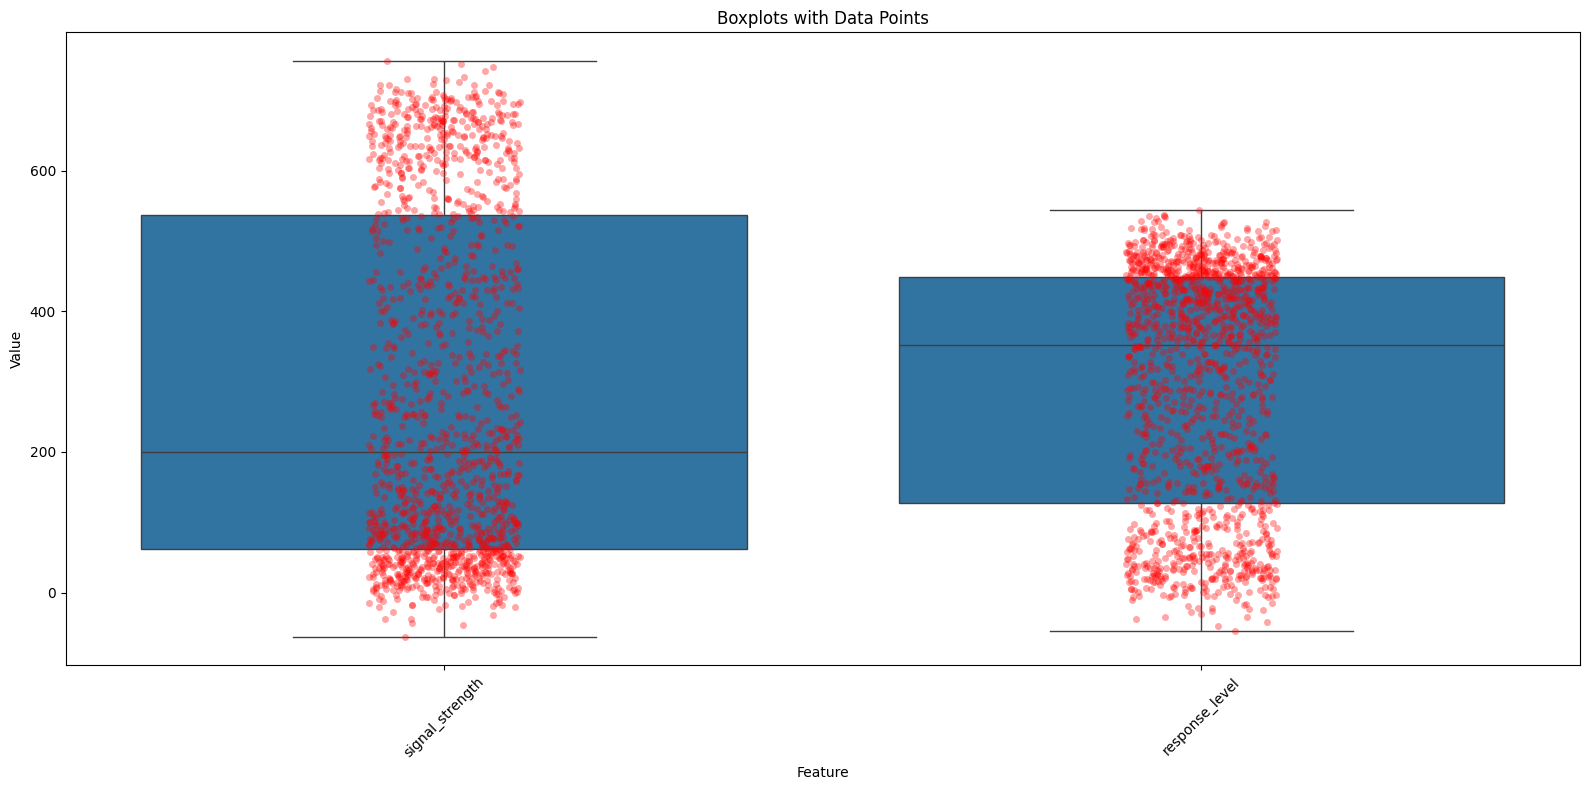

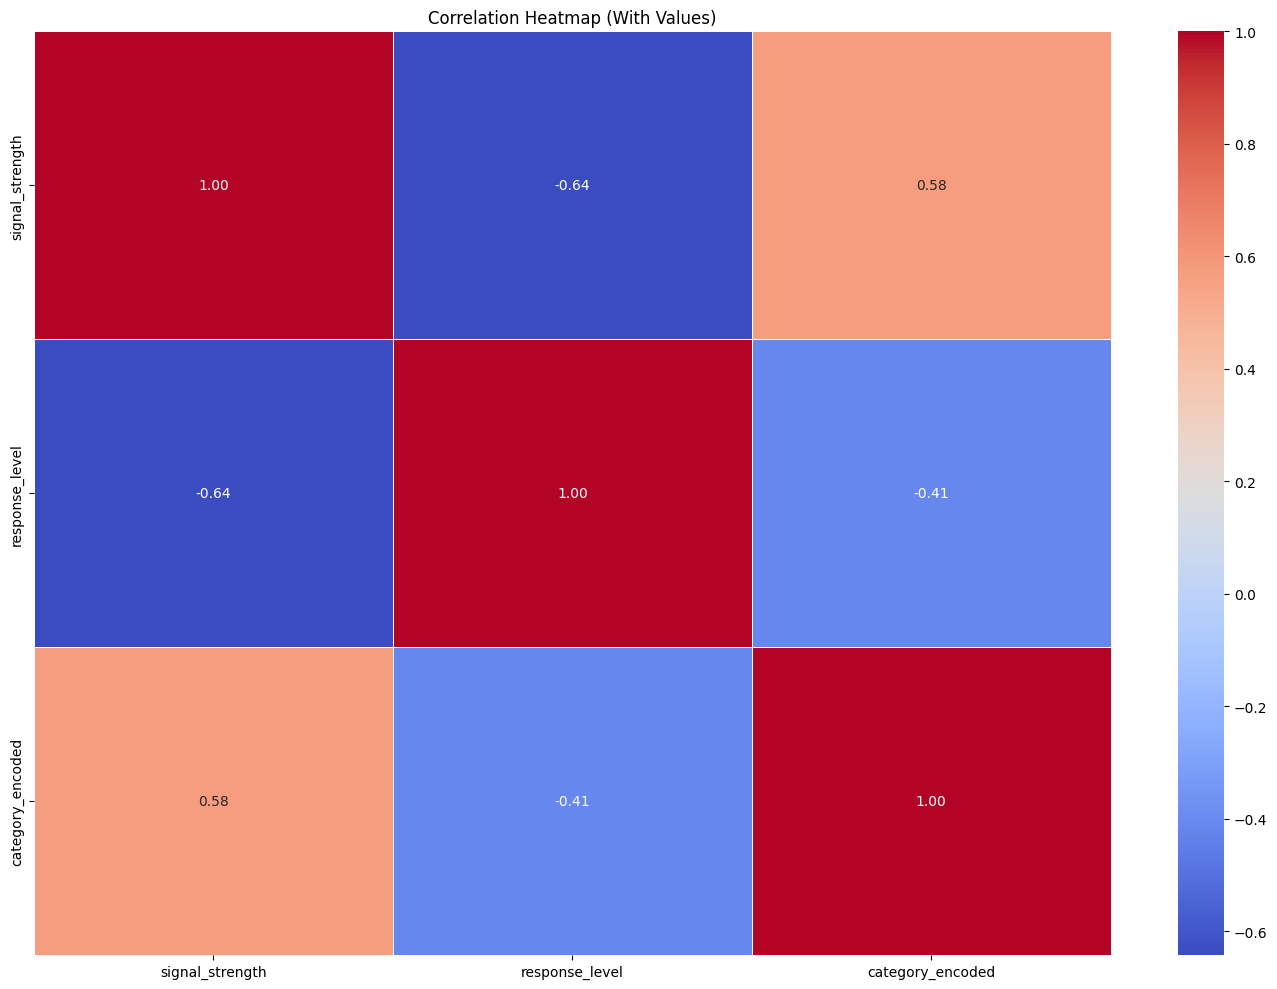

In [3]:
# -------------------------------
# Basic info
# -------------------------------
print("\n===== SHAPE =====")
print(df.shape)

print("\n===== MISSING VALUES =====")
print(df.isna().sum())

print("\n===== BASIC DESCRIPTIVE STATS =====")
print(df.describe())

# -------------------------------
# Numeric columns
# -------------------------------
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
print("\nNumeric columns:", numeric_cols)

# -------------------------------
# Boxplots WITH DATA POINTS
# -------------------------------
plt.figure(figsize=(16, 8))

# Melt numeric columns for single-axis plotting
df_melt = df[numeric_cols].melt(var_name="Feature", value_name="Value")

sns.boxplot(data=df_melt, x="Feature", y="Value", showfliers=True)
sns.stripplot(data=df_melt, x="Feature", y="Value", color='red', alpha=0.35)

plt.title("Boxplots with Data Points")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Correlation including encoded target
# -------------------------------
le = LabelEncoder()
df["category_encoded"] = le.fit_transform(df[target_col])

corr_cols = numeric_cols + ["category_encoded"]
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix, 
    cmap="coolwarm", 
    annot=True,          # <<< SHOW VALUES INSIDE PLOT
    fmt=".2f",           # number formatting
    linewidths=0.5
)
plt.title("Correlation Heatmap (With Values)")
plt.tight_layout()
plt.show()

In [4]:
#=====================================================
# FUNCTION: Train-evaluate-predict for a given split
#=====================================================
def run_experiment(test_size):
    print(f"\n========== Running experiment with test_size={test_size} ==========\n")

    # 1. Split training data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # 2. SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # 3. MODELS + GRID SEARCH
    models = {
        "SVM": GridSearchCV(
            Pipeline([
                ("scaler", StandardScaler()),
                ("svm", SVC(probability=True))
            ]),
            param_grid={
                "svm__C": [0.01, 0.1, 1, 10],
                "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],
                "svm__gamma": ["scale", "auto"]
            },
            cv=3, scoring="accuracy", n_jobs=-1
        ),

        "MLP": GridSearchCV(
            Pipeline([
                ("scaler", StandardScaler()),
                ("mlp", MLPClassifier(max_iter=2000))
            ]),
            param_grid={
                "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50)],
                "mlp__activation": ["relu", "tanh"],
                "mlp__solver": ["adam", "sgd"]
            },
            cv=3, scoring="accuracy", n_jobs=-1
        ),

        "KNN": GridSearchCV(
            Pipeline([
                ("scaler", StandardScaler()),
                ("knn", KNeighborsClassifier())
            ]),
            param_grid={
                "knn__n_neighbors": [3, 5, 7],
                "knn__weights": ["uniform", "distance"]
            },
            cv=3, scoring="accuracy", n_jobs=-1
        ),

        "RandomForest": GridSearchCV(
            RandomForestClassifier(),
            param_grid={
                "n_estimators": [100, 200],
                "max_depth": [5, 10, 20]
            },
            cv=3, scoring="accuracy", n_jobs=-1
        ),

        "Logistic Regression": GridSearchCV(
            Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(max_iter=2000))
            ]),
            param_grid={"lr__C": [0.01, 0.1, 1, 10]},
            cv=3, scoring="accuracy", n_jobs=-1
        ),

        "Decision Tree": GridSearchCV(
            DecisionTreeClassifier(),
            param_grid={
                "max_depth": [3, 5, 10, 20],
                "criterion": ["gini", "entropy"]
            },
            cv=3, scoring="accuracy", n_jobs=-1
        ),

        "Gradient Boosting": GridSearchCV(
            GradientBoostingClassifier(),
            param_grid={
                "learning_rate": [0.01, 0.1],
                "n_estimators": [100, 200]
            },
            cv=3, scoring="accuracy", n_jobs=-1
        ),
        "Naive Bayes": GridSearchCV(
            GaussianNB(),
            param_grid={"var_smoothing": np.logspace(-9, -1, 9)},
            cv=3, scoring="accuracy", n_jobs=-1
        ),

    }

    accuracy_dict = {}

    #=====================================================
    # TRAIN / VALIDATE / PREDICT
    #=====================================================
    for name, model in models.items():
        print(f"Training {name}...")

        # Fit model
        model.fit(X_train_res, y_train_res)

        # Predict validation set
        y_val_pred = model.predict(X_val)

        # Accuracy
        acc = accuracy_score(y_val, y_val_pred)
        accuracy_dict[name] = acc

        print(f"  ✔ Validation Accuracy = {acc:.4f}")

        # Predict on real test.csv
        y_test_pred = model.predict(X_test_final)

        # Output file
        out_filename = f"{name.replace(' ','_').lower()}_pred_split_{test_size}.csv"

        pd.DataFrame({
            "sample_id": test_sample_ids,
            "category": y_test_pred
        }).to_csv(out_filename, index=False)

        print(f"  ✔ Test-set predictions saved to: {out_filename}\n")

    return accuracy_dict



#=====================================================
# RUN BOTH SPLITS
#=====================================================
acc_20 = run_experiment(test_size=0.20)
acc_80 = run_experiment(test_size=0.80)


#=====================================================
# COMPARISON TABLE
#=====================================================
comparison = pd.DataFrame({
    "Accuracy (20% test)": acc_20,
    "Accuracy (80% test)": acc_80,
})

comparison["Difference"] = comparison["Accuracy (80% test)"] - comparison["Accuracy (20% test)"]
comparison = comparison.sort_values("Difference")

print("\n================= ACCURACY COMPARISON =================\n")
print(comparison)
print("\n=======================================================\n")


========== Running experiment with test_size=0.2 ==========

Training SVM...
  ✔ Validation Accuracy = 0.9827
  ✔ Test-set predictions saved to: svm_pred_split_0.2.csv

Training MLP...
  ✔ Validation Accuracy = 0.9827
  ✔ Test-set predictions saved to: mlp_pred_split_0.2.csv

Training KNN...
  ✔ Validation Accuracy = 0.9827
  ✔ Test-set predictions saved to: knn_pred_split_0.2.csv

Training RandomForest...
  ✔ Validation Accuracy = 0.9827
  ✔ Test-set predictions saved to: randomforest_pred_split_0.2.csv

Training Logistic Regression...
  ✔ Validation Accuracy = 0.9100
  ✔ Test-set predictions saved to: logistic_regression_pred_split_0.2.csv

Training Decision Tree...
  ✔ Validation Accuracy = 0.9723
  ✔ Test-set predictions saved to: decision_tree_pred_split_0.2.csv

Training Gradient Boosting...
  ✔ Validation Accuracy = 0.9758
  ✔ Test-set predictions saved to: gradient_boosting_pred_split_0.2.csv

Training Naive Bayes...
  ✔ Validation Accuracy = 0.9273
  ✔ Test-set predictions sa